# General Concepts (with a time dependent problem)
In the following we introduce how to construct and use the basic components of
a finite element method ending with solving a heat equation.
The required steps are:

*  constructing a tessellation of the computational domain (**hierarchical grid** and **grid view**)
*  working with functions defined over the grid (**grid functions**)
*  setting up **discrete spaces** and **discrete functions**
*  defining the mathematical model to solve (**ufl**)
*  solving the (non linear) system arising from the discretization of the
   model by the Galerkin method (**scheme**)

.. index::
   triple: Grids; Hierarchical Grids; Grid Definition

## Setting up the Grid

.. attention::
   The goal of a Dune **grid** or **hierarchical grid** is to provide an
   interface to describe subdivisions (entities or elements for codim 0) of the computational domain $\Omega$
   in a generic way. In the following this is referred to as `hierarchicalGrid`.
   See <cite data-cite="DuneReview"></cite>, Section 3.1, for more details.

.. note::
   Grids can be refined in a hierarchic manner, meaning that elements are subdivided into several smaller elements. The
   element to be refined is kept in the grid and remains accessible. One
   can either refine all elements (global refinement) as described below.
   We will discuss [local refinement](gridviews_and_adaptivity.rst#Dynamic-Local-Grid-Refinement-and-Coarsening)
   in a later section.

After some general import statements we start our tutorial by setting up
a simple Cartesian grid over the domain $\Omega = [0,1]^2$ subdivided into four
intervals in each dimension. We can then show the grid using the `plot`
method - note that direct plotting with MatPlotLib is only supported in
2D, other options for visualization, e.g., using ParaView will be
discussed later.

Using the `dune.grid.structuredGrid` function is the simplest way to construct
a grid, more complicated
(unstructured) grids can be constructed using a dictionary containing the
vertices and the element connectivity or by for example providing a
`gmsh` file. This will be discussed in later section, see for example
here for [a 3d gmsh file](othergrids_nb.ipynb)
or here [for a simple example using a dictionary](dune-corepy_nb.ipynb#Unstructured-grids).

.. index::
   pair: Grids; Plotting


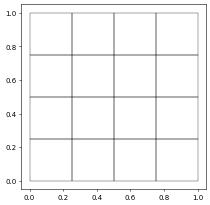

In [1]:
from matplotlib import pyplot as plt
import numpy as np

from dune.grid import structuredGrid as leafGridView
gridView = leafGridView([0, 0], [1, 1], [4, 4])
gridView.plot()

Often the initial grid is a bit coarse - it is very easy to refine it
globally.

.. index::
   pair: Grid view; Grid view Definition

.. attention:: A **grid view** object provides read-only access to the entities of all codimensions
of a subset of the `hierarchical grid`.
In the following this is called `gridView` and sometimes simply `grid`.
See <cite data-cite="DuneReview"></cite>, Section 3.1.1, for more details.

.. tip:: The functions constructing a grid generally return a **leaf grid view**,
i.e., only contains of a view of the finest grid elements.
We also provide some special grid views to for example simulate on
[evolving domains](gridviews_and_adaptivity.rst#Evolving-Domains) or
to simplify efficient [local grid adaptivity](gridviews_and_adaptivity.rst#Dynamic-Local-Grid-Refinement-and-Coarsening).

Since a `gridView` can not be changed
directly we need to access the underlying `hierarchicalGrid` to perform
e.g. grid refinement. So to globally refine the grid call

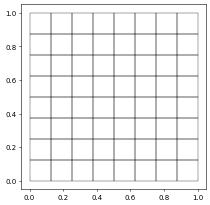

In [2]:
gridView.hierarchicalGrid.globalRefine(1)
gridView.plot()

If `level>0` then the
grid is refined down by the given level and `level<0` leads to global
coarsening of the grid by the given number of levels (if possible).

.. tip:: The effect of this refinement will depend on the underlying
grid manager. For Cartesian grid for example refining by one level leads
a reduction of the grid spacing by 2 while for a bisection grid in $d$
space dimensions one needs to refine by $2^{d-1}$ levels to achieve the same effect.

In addition to the `globalRefine` method on the `hierarchicalGrid`
`dune-fem` also provides a `globalRefine` function, which takes the
`level` as the first argument and a hierarchical grid as second argument.
This method can also be used to prolong and restrict discrete functions
as will be discussed in [a later section](gridviews_and_adaptivity.rst#Dynamic-Local-Grid-Refinement-and-Coarsening).

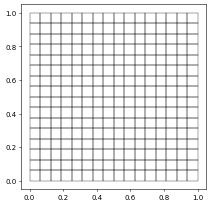

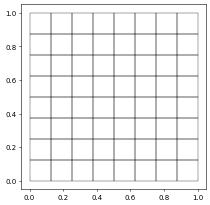

In [3]:
from dune.fem import globalRefine
globalRefine(1,gridView.hierarchicalGrid)  # the first argument is the number of refinements to perform
gridView.plot()
globalRefine(-1,gridView.hierarchicalGrid) # coarsen again by one level
gridView.plot()

.. index::
   pair: Functions; Grid Functions

## Grid Functions

.. attention::
A **grid function** is a function that is defined
over a given grid view and is evaluated by using an element
of this view and local coordinate within that element, e.g., a quadrature point.

For example:
```
   value = gridFunction(element,localCoordinate)
```
Alternatively one can obtain a `LocalFunction` from a grid function which
can be bound to an element and then evaluate via local coordinate:
```
   localFunction = gridFunction.localFunction()
   for e in grid.elements:
       localFunction.bind(e)
       value = localFunction(x)
       localFunction.unbind()
```
There are multiple ways to construct grid functions. The easiest way it
to use UFL expression. Many methods expecting grid functions as argument
can also directly handle UFL expression.
We can for example integrate a UFL expression over the grid:

In [4]:
from ufl import SpatialCoordinate
from dune.ufl import cell
x = SpatialCoordinate(cell(2))

exact = 1/2*(x[0]**2+x[1]**2) - 1/3*(x[0]**3 - x[1]**3) + 1

from dune.fem import integrate
print( integrate(exact, gridView=gridView, order=5) )

1.3333333333333324


.. index::
   pair: I/O; VTK files

and plot them using matplotlib or write a vtk file for postprocessing

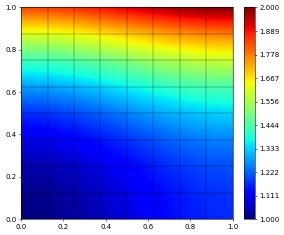

In [5]:
from dune.fem.plotting import plotPointData as plot
plot(exact, gridView=gridView)
gridView.writeVTK('exact', pointdata={'exact': exact})

In some cases it can be necessary to convert a UFL expression into a grid
function explicitly - for example to be able to evaluate it over each
element in the grid ([in a later section](dune-corepy_nb.ipynb)
we provide more detail on how to access the grid interface).

.. index::
   pair: dune.fem.function; gridFunction

.. note:: ``dune.fem.function.gridFunction`` provides different options for
constructing grid functions: it can be used as decorator of Python
function, provided with a C++ code snippet, or an ufl expression.

.. index::
   triple: Functions; dune.fem.function; ufl grid function

We will discuss the second usages later and have some example for using
C++ code snippets [in a later section](cppfunctions_nb.ipynb).
If the first argument `expr`
is a ufl expression then a grid function is generated
which can be efficiently evaluated on both the Python and the C++ side.

.. tip:: Especially in time critical parts of the code the usage of
   ``gridFunction`` is strongly encouraged to speed up simulations.

Like ``assemble`` and ``integrate``, `gridFunction` takes two additional
arguments ``order`` and ``gridView``. These are required arguments if a
code snippet is used or the ``gridView`` is used as a decorator. If the
basis of the grid function is a ufl expression these can be omitted in
many cases where they can be determined from the expression itself. See the
[introduction](dune-fempy_nb.ipynb) for more detail.

In the next example the ``gridView`` argument is required:

In [6]:
from dune.fem.function import gridFunction
exact_gf = gridFunction(exact, gridView, name="ufl")
mass = 0
for element in gridView.elements:
    mass += exact_gf(element,[0.5,0.5]) * element.geometry.volume
print(mass)

1.33203125


.. index::
   triple: Functions; dune.fem.function; grid function decorator

Another way to obtain a grid function is to use the `gridFunction` as
decorator. This can be obtained from `dune.grid` but then without UFL
support. Using the decorator from `dune.fem.function` the resulting grid
function can be used seamlessly within UFL expressions:

In [7]:
from dune.fem.function import gridFunction
@gridFunction(gridView,name="callback",order=1)
def exactLocal(element,xLocal):
    x = element.geometry.toGlobal(xLocal)
    return 1/2.*(x[0]**2+x[1]**2) - 1/3*(x[0]**3 - x[1]**3) + 1

We can use the same approach but with a function using global
coordinates but can then be used like any other grid function:

In [8]:
@gridFunction(gridView,name="callback",order=1)
def exactGlobal(x):
    return 1/2.*(x[0]**2+x[1]**2) - 1/3*(x[0]**3 - x[1]**3) + 1

lf = exactGlobal.localFunction()

mass = 0
for element in gridView.elements:
    lf.bind(element)
    mass += lf([0.5,0.5]) * element.geometry.volume
    lf.unbind()
print(mass)

1.33203125


.. index::
   pair: Functions; UFL functions

As pointed out the `dune.fem` grid function can be used like any other
UFL coefficient to form UFL expressions:

0.0


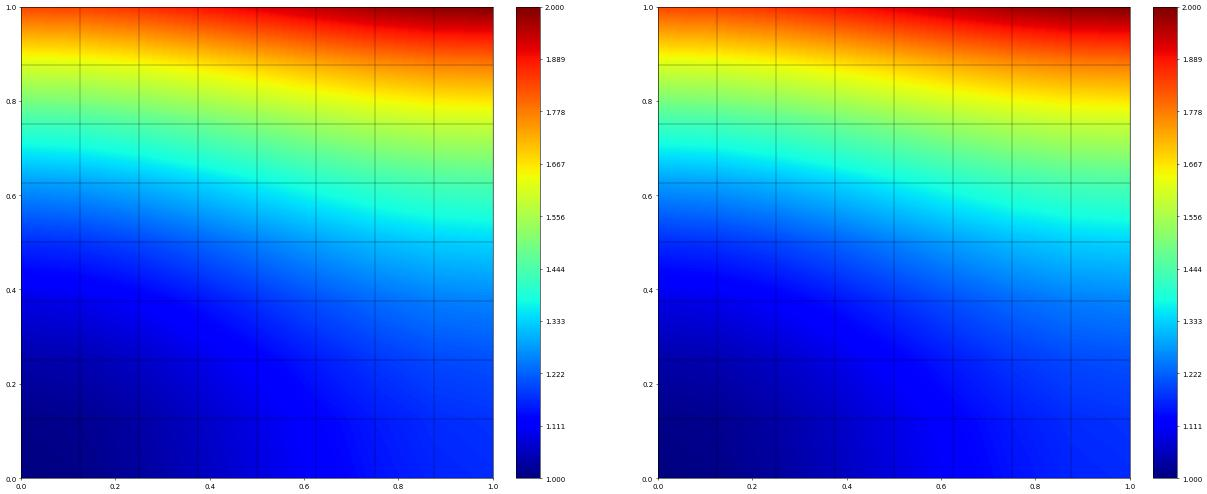

In [9]:
print( integrate(abs(exact-exactLocal)) )
gf = gridFunction(exact-exactLocal+exactGlobal, name="ufl")
fig = plt.figure(figsize=(25,10))
gf.plot(figure=(fig,121))
exactGlobal.plot(figure=(fig,122))

Converting UFL expressions to grid functions leads to JIT code generation
and is therefore efficient when used in other C++ algorithm (like
`integrate`). But more complex control structures are hard to express
within UFL. On the other hand using the `gridFunction` decorator leads
to a callback into Python for each evaluation and is therefore much less
efficient. An alternative approach is based on writing small C++ snippets
implementing the grid function as described in the section on
generating
[C++ Based Grid Functions](cppfunctions_nb.ipynb).


.. index::
   pair: Spaces; Lagrange Space

## Discrete Spaces

The grid functions set up so far did not involve any
discretization, they are exactly evaluated at the given point. We next
discuss functions over finite dimensional (discrete) spaces.

.. attention::
A **discrete (function) space** is a finite dimensional function space
defined over a given grid view. Typically these are Finite Element
spaces.

Let us start with a Lagrange finite element space consisting of piecewise
quadratic functions (``order=2``):

In [10]:
from dune.fem.space import lagrange as solutionSpace
space = solutionSpace(gridView, order=2)


A list of available spaces is shown at the bottom of this page.
The main method on the space is ``interpolate`` that returns an
element of the space (a discrete function) applying the natural
interpolation into the space to a given (ufl) expression.
This is explained in detail in the next section.

.. tip::
   In addition to the ``order`` argument most spaces take an additional
   ``dimRange`` argument to construct vector valued spaces $V^n$. Note
   that by default a scalar space is constructed which differs in usage
   from the space with ``dimRange=1``. Discrete function over the latter
   have to be treated as vector valued functions of dimension one, e.g.,
   instead of ``uh*uh`` one needs ``uh[0]*uh[0]`` or ``ufl.dot(uh,uh)``.

Two other methods on the discrete spaces worth noting provide access to the local to global dof
mapper and evaluate the basis functions.

First we have the ``mapper`` method. This returns a callable object which
for a given element in the grid, returns the vector of global indices for
the basis functions with support on the element:

In [11]:
mapper = space.mapper()
for i,element in enumerate(gridView.elements):
    print( mapper(element) )
    if i == 4: break # only show indices for first few elements

[0, 81, 1, 153, 225, 154, 9, 89, 10]
[1, 82, 2, 154, 226, 155, 10, 90, 11]
[2, 83, 3, 155, 227, 156, 11, 91, 12]
[3, 84, 4, 156, 228, 157, 12, 92, 13]
[4, 85, 5, 157, 229, 158, 13, 93, 14]



To access the basis functions with support on an element we provide the
method ``evaluateBasis``, ``jacobianBasis``:

In [12]:
localPoint = [0.1,0.1] # this is in the reference element
for i,element in enumerate(gridView.elements):
    print( space.evaluateBasis(element, localPoint) )
    if i == 4: break
# The next line fails on MacOS (with a Bus Error 10)
# (tested 28/04/2024). Removed for now
# print("convert to a numpy array:", np.array( space.jacobianBasis(element, localPoint) ) )

[Dune::FieldVector<1>(0.518400), Dune::FieldVector<1>(0.259200), Dune::FieldVector<1>(-0.057600), Dune::FieldVector<1>(0.259200), Dune::FieldVector<1>(0.129600), Dune::FieldVector<1>(-0.028800), Dune::FieldVector<1>(-0.057600), Dune::FieldVector<1>(-0.028800), Dune::FieldVector<1>(0.006400)]
[Dune::FieldVector<1>(0.518400), Dune::FieldVector<1>(0.259200), Dune::FieldVector<1>(-0.057600), Dune::FieldVector<1>(0.259200), Dune::FieldVector<1>(0.129600), Dune::FieldVector<1>(-0.028800), Dune::FieldVector<1>(-0.057600), Dune::FieldVector<1>(-0.028800), Dune::FieldVector<1>(0.006400)]
[Dune::FieldVector<1>(0.518400), Dune::FieldVector<1>(0.259200), Dune::FieldVector<1>(-0.057600), Dune::FieldVector<1>(0.259200), Dune::FieldVector<1>(0.129600), Dune::FieldVector<1>(-0.028800), Dune::FieldVector<1>(-0.057600), Dune::FieldVector<1>(-0.028800), Dune::FieldVector<1>(0.006400)]
[Dune::FieldVector<1>(0.518400), Dune::FieldVector<1>(0.259200), Dune::FieldVector<1>(-0.057600), Dune::FieldVector<1>(0.


.. index::
   pair: Functions; Discrete Functions

## Discrete Functions

.. attention::
A special type of grid function is a **discrete function** living in a
discrete (finite dimensional) space. The main property of a discrete
function is that it contains a **dof vector**.
[In a later section](solversExternal_nb.ipynb)
we will see how to extract the underlying dof vector in the form of a `numpy` or a `petsc` vector.


The easiest way to construct a discrete function is to use the `interpolate`
method on the discrete function space to create an initialized discrete
function or `function` to create a discrete function initialized with $\mathbf{0}$.

In [13]:
# initialized with an analytical expression
u_h = space.interpolate(exact, name='u_h')

# initialized with zeros
u_h = space.function(name='u_h')

On an existing discrete function the `interpolate` method can be used to
reinitialize it

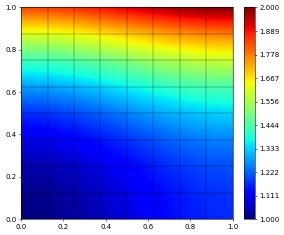

In [14]:
u_h.interpolate( lambda x: 1/2.*(x[0]**2+x[1]**2) - 1/3*(x[0]**3 - x[1]**3) + 1 )
u_h.plot()

Note that in the last example the Python lambda is used as a callback
automatically using the same concept used in the `gridFunction`
decorator. As pointed out above there are some methods where these
conversions are implicit and no explicit generation of a grid function
has to be carried out.

If a discrete function is already available it is possible to call `copy`
to obtain further discrete functions:

In [15]:
u_h_n = u_h.copy(name="previous")

Finally, `clear` can be called on a discrete function which sets all
coefficient to zero and `assign` can be used to copy all coefficients
between two discrete function over the same space:

In [16]:
u_h_n.clear()
u_h_n.assign( u_h )

All the things we did above with grid functions can be done with discrete
functions, e.g., evaluate locally

In [17]:
localUh = u_h.localFunction()
mass = 0
for element in gridView.elements:
    localUh.bind(element) # using u_h(element,[0.5,0.5]) also works
    mass += localUh([0.5,0.5]) * element.geometry.volume
    localUh.unbind()
print(mass)

1.33203125


.. index::
   pair: Functions; Plotting

.. index::
   pair: I/O; VTK files

or plot using matplotlib and write a vtk file for postprocessing
(using binary data format to reduce size)

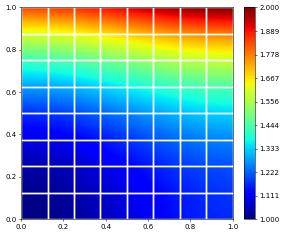

In [18]:
u_h.plot(gridLines="white", linewidth=2)
from dune.grid import OutputType
gridView.writeVTK('uh', pointdata=[u_h])


.. tip:: The discrete function `u_h` already has a `name` attribute given in
the `interpolate` call. This is used by default in the vtk file. An
alternative name can be given by using a dictionary as shown previously.

Of course a discrete function can also be used as a coefficient in a UFL expression

In [19]:
print( integrate(abs(exact-u_h)) )

3.1323256792013636e-05


The main difference between a grid function and a discrete function is
that the latter has a `dofVector` attached to it. We can iterate over
that easily

In [20]:
for d in u_h.dofVector:
    print(d,end=", ")
print()

1.0, 1.0071614583333333, 1.0260416666666667, 1.052734375, 1.0833333333333333, 1.1139322916666667, 1.140625, 1.1595052083333333, 1.1666666666666667, 1.0084635416666667, 1.015625, 1.0345052083333333, 1.0611979166666667, 1.091796875, 1.1223958333333333, 1.1490885416666667, 1.16796875, 1.1751302083333335, 1.0364583333333333, 1.0436197916666667, 1.0625, 1.0891927083333333, 1.1197916666666667, 1.150390625, 1.1770833333333333, 1.1959635416666667, 1.203125, 1.087890625, 1.0950520833333333, 1.1139322916666667, 1.140625, 1.1712239583333333, 1.2018229166666667, 1.228515625, 1.2473958333333333, 1.2545572916666667, 1.1666666666666667, 1.173828125, 1.1927083333333333, 1.2194010416666667, 1.25, 1.2805989583333333, 1.3072916666666667, 1.326171875, 1.3333333333333335, 1.2766927083333333, 1.2838541666666665, 1.302734375, 1.3294270833333333, 1.3600260416666667, 1.390625, 1.4173177083333333, 1.4361979166666667, 1.443359375, 1.421875, 1.4290364583333333, 1.4479166666666665, 1.474609375, 1.5052083333333335,

In addition to `clear` and `assign` we can also add (scalar
multiples of) discrete functions together or multiply them by a scalar
which will directly change the underlying dofVector - this can only be
done __in place__, so `u_h *= 2` changes the dof vector while
`u_h*2` results in an UFL expression. Here are some examples:

In [21]:
u_h_n *= 2
u_h   += u_h_n
# this is equivalent to
u_h.axpy(2,u_h_n)

We started with `u_h_n=u_h` so after these changes each dof in
`u_h` should be seven times its original value

In [22]:
for d in u_h.dofVector:
    print(d,end=", ")
print()

7.0, 7.050130208333333, 7.182291666666667, 7.369140625, 7.583333333333333, 7.797526041666667, 7.984375, 8.116536458333332, 8.166666666666668, 7.059244791666667, 7.109375, 7.241536458333333, 7.428385416666667, 7.642578125, 7.856770833333333, 8.043619791666668, 8.17578125, 8.225911458333334, 7.255208333333333, 7.305338541666667, 7.4375, 7.624348958333333, 7.838541666666667, 8.052734375, 8.239583333333332, 8.371744791666668, 8.421875, 7.615234375, 7.665364583333333, 7.797526041666667, 7.984375, 8.198567708333332, 8.412760416666668, 8.599609375, 8.731770833333332, 8.781901041666668, 8.166666666666668, 8.216796875, 8.348958333333332, 8.535807291666668, 8.75, 8.964192708333332, 9.151041666666668, 9.283203125, 9.333333333333334, 8.936848958333332, 8.986979166666666, 9.119140625, 9.305989583333332, 9.520182291666668, 9.734375, 9.921223958333332, 10.053385416666668, 10.103515625, 9.953125, 10.003255208333332, 10.135416666666666, 10.322265625, 10.536458333333334, 10.750651041666666, 10.9375, 11.

.. index::
   triple: Models; Schemes; Operators

## Operators and Schemes

In the [previous section](dune-fempy_nb.ipynb) we have already seen how to
assemble system matrices for linear PDEs and how to construct schemes for
non-linear problems. We also discussed that we can directly use grid
functions and ``dune.ufl.Constant`` instances within UFL expressions
and forms - in the final example of this section we will give an example for this in the
context of a time dependent problems.

.. tip:: The main advantage of using
   ``dune.ufl.Constant`` and grid functions is to be able to change details in
   a form without requiring any recompilation of the model. An example
   would be in a time dependent problem a time varying coefficient or
   changing the time step adaptively during the simulation.

Let us first consider a simple linear elliptic problem
$$ -\triangle u + \alpha u = f $$
with Dirichlet and Neuman boundary data given by $g_D,g_N$ and
where $\alpha$ is a real valued parameter.
We choose $f,g_N,g_D$ so that the exact solution for $\alpha=0$
is given by
\begin{align*}
u(x) = \left(\frac{1}{2}(x^2 + y^2) - \frac{1}{3}(x^3 - y^3)\right) + 1
\end{align*}
which is the grid function ``exact`` we have already defined above.

.. index:: DirichletBC; DirichletBC Definition

.. note:: The class `dune.ufl.DirichletBC` is used to fix Dirichlet conditions
   $u=g$ on $\Gamma\subset\partial\Omega$.
   It constructor takes three arguments: the discrete space for $u$,
   the data $g$, and a description of $\Gamma$. Multiple
   instances can be used to fix Dirichlet conditions on different parts of the boundary
   as described in the Section on [general boundary conditions](boundary_nb.ipynb).

To assemble a system matrix from a ufl form one can either use
`dune.fem.assemble` which is especially useful for simple linear models
as discussed in the [previous section](dune-fempy_nb.ipynb). For more
control one should use `schemes` or `operators`:

.. index:: Scheme; Scheme Definition

.. attention::
   A **scheme** implements a Galerkin scheme for a given
   weak form for a wide range of PDEs, where the model (integrands) is provided as ufl form.
   Mathematically a `scheme` implements an operator $L\colon V_h\to V_h$
   with equal (discrete) domain and range space. The `scheme`
   provides a `solve` method which computes $u=L^{-1}(g)$ for
   given $g$. By default a root of $L$ is computed but
   a right hand side $g$ can be provided to solve $L[u_h]=g$.

.. index:: Operator; Operator Definition

.. note:: The more general case is
   covered by classes in `dune.fem.operator` for **operators** $L\colon V_h\to W_h$
  with different domain and range spaces. See
  [here](scheme_api.rst) for more details on the concepts and a summary of the API for operators and
  schemes.

In [23]:
from ufl import (TestFunction, TrialFunction, SpatialCoordinate, FacetNormal,
                 dx, ds, grad, div, inner, dot, sin, cos, pi, conditional)
from dune.ufl import Constant, DirichletBC
from dune.fem.scheme import galerkin as solutionScheme

alpha = Constant(1,name="mass")   # start with alpha=1
x     = SpatialCoordinate(space)
u     = TrialFunction(space)
v     = TestFunction(space)
f     = -div( grad(exact) )
g_N   = grad(exact)
n     = FacetNormal(space)
b     = f*v*dx + dot(g_N,n)*conditional(x[0]>=1e-8,1,0)*v*ds
a     = dot(grad(u), grad(v)) * dx + alpha*u*v * dx
dbc   = DirichletBC(space,exact,x[0]<=1e-8)

scheme = solutionScheme([a == b, dbc], solver='cg')
scheme.solve(target = u_h)

h1error = dot(grad(u_h - exact), grad(u_h - exact))
error = np.sqrt(integrate(h1error))
print("Number of elements:",gridView.size(0),
      "number of dofs:",space.size,"H^1 error:", error)

Number of elements: 64 number of dofs: 289 H^1 error: 0.5635700799030048



.. index:: Constants; Constant Definition

.. note:: The **dune.ufl.Constant** class implements a scalar or vector
   valued constant with a name. This constant can be used within a ufl form
   and after the ufl form was converted into a `scheme` or `operator` the
   given name can be used to change the constant within the form
   efficiently, e.g., we can adapt the point in time or time step during the
   simulation without requiring any additional just in time compilation.

Instances of ``dune.ufl.Constant`` have an attribute
``value`` to read and change the constant. Setting the value,
will change it everywhere it is used.
In addition a ``scheme``/``operator`` provides the attribute ``model``
which has an attribute ``name`` for each constant
with name `name` contained in the ufl form used to construct the
``scheme``/``operator``.  Cchanging the value of the constants through
the ``model`` attribute only changes it within that model and not globally.


In [24]:
print(scheme.model.mass, alpha.value)
scheme.model.mass = 2
print(scheme.model.mass, alpha.value)
alpha.value = 0
print(scheme.model.mass, alpha.value)

1.0 1.0
2.0 1.0
0.0 0.0


Note that now $\alpha=0$ so we have the correct exact solution and can
compute the errors:

Number of elements: 64 number of dofs: 289 H^1 error: 0.0016470196146885843


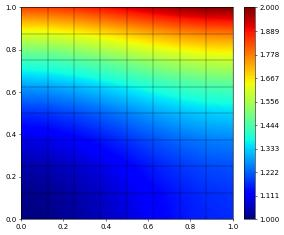

In [25]:
scheme.solve(target = u_h)

h1error = dot(grad(u_h - exact), grad(u_h - exact))
error = np.sqrt(integrate(h1error))
print("Number of elements:",gridView.size(0),
      "number of dofs:",space.size,"H^1 error:", error)
u_h.plot()

Or switch to $\alpha=1$ to directly solve a different PDE without needing
to recompile anything:

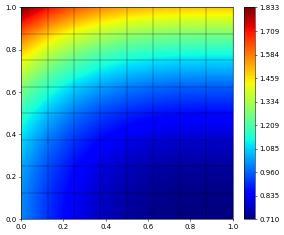

In [26]:
alpha.value = 1
scheme.solve(target = u_h)
u_h.plot()

.. tip:: Changing the values of constants using the ``value`` attribute
   on ``dune.ufl.Constant`` is generally the option with the least chance
   for surprise.
   The ``scheme.model.name`` approach is useful if the instance of
   ``dune.ufl.Constant`` is not available anymore, e.g., a ``scheme`` was
   returned by some function which constructed the constants as local
   variables.

.. index:: Equations; Non-linear parabolic

## A Nonlinear Time Dependent Problem

As a final example in this section we will study the Forchheimer problem
<cite data-cite="Kieu"></cite>
which is a scalar, nonlinear parabolic equation
\begin{equation}
\partial_tu - \nabla\cdot K(\nabla u)\nabla u = f
\end{equation}
where the diffusion tensor is given by
\begin{equation}
K(\nabla u) = \frac{2}{1+\sqrt{1+4|\nabla u|}}
\end{equation}
and $f=f(x,t)$ is some time dependent forcing term.
On the boundary we prescribe Neumann boundary
and initial conditions $u=u_0$.

We will solve this problem in variational form and using the Crank
Nicolson method for the time discretization

\begin{equation}
\begin{split}
\int_{\Omega} \frac{u^{n+1}-u^n}{\Delta t} \varphi
+ \frac{1}{2}K(\nabla u^{n+1}) \nabla u^{n+1} \cdot \nabla \varphi \
+ \frac{1}{2}K(\nabla u^n) \nabla u^n \cdot \nabla \varphi v\ dx \\
- \int_{\Omega} \frac{1}{2}(f(x,t^n)+f(x,t^n+\Delta t) \varphi\ dx
- \int_{\partial \Omega} \frac{1}{2}(g(x,t^n)+g(x,t^n+\Delta t)) v\ ds = 0.
\end{split}
\end{equation}

on a domain $\Omega=[0,1]^2$. We choose $f,g$ so that the exact solution
is given by
\begin{align*}
u(x,t) = e^{-2t}\left(\frac{1}{2}(x^2 + y^2) - \frac{1}{3}(x^3 - y^3)\right) + 1
\end{align*}
We solve this problem using a quadratic finite element space.
We first setup this space, define the initial data,
and a second discrete function to store
the solution at the current time step (``u_h`` will be used to store the
next time step):

In [27]:
space = solutionSpace(gridView, order=2)
u_h   = space.function(name='u_h')
u_h_n = u_h.copy(name="previous")

x = SpatialCoordinate(space)
initial = 1/2*(x[0]**2+x[1]**2) - 1/3*(x[0]**3 - x[1]**3) + 1

Next we setup the form $a=a(u,v)$ which depends on time $t$ and the
chosen time step $\Delta t$. Since we want to be able to change these
during the simulation (we need to do this for $t$ and might want to do
this for $\Delta t$ we use the ``dune.ufl.Constant`` which stores a
mutable scalar and can be used within a ufl expression:

In [28]:
from dune.fem.scheme import galerkin as solutionScheme
from ufl import FacetNormal, ds, dx, inner, dot, div, grad, sqrt, exp, TrialFunction, TestFunction
from dune.ufl import Constant
dt = Constant(0, name="dt")    # time step
t  = Constant(0, name="t")     # current time
u = TrialFunction(space)
v = TestFunction(space)

abs_du = lambda u: sqrt(inner(grad(u), grad(u)))
K = lambda u: 2/(1 + sqrt(1 + 4*abs_du(u)))
a = ( dot((u - u_h_n)/dt, v) \
    + 0.5*dot(K(u)*grad(u), grad(v)) \
    + 0.5*dot(K(u_h_n)*grad(u_h_n), grad(v)) ) * dx

To define the right hand side we use the given function $u$ to define
the forcing $f$ and the boundary flux $g$

In [29]:
exact = lambda t: exp(-2*t)*(initial - 1) + 1
f     = lambda s: -2*exp(-2*s)*(initial - 1) - div( K(exact(s))*grad(exact(s)) )
g = lambda s: K(exact(s))*grad(exact(s))
n = FacetNormal(space)
b = 0.5*(f(t)+f(t+dt))*v*dx + 0.5*dot(g(t)+g(t+dt),n)*v*ds

With the model described as a ufl form, we can again construct a scheme class
that provides the solve method which we can use to evolve the solution from
one time step to the next. As already mentioned the solve methods always assumes
that the problem is non-linear and use a Newton method to solve the problem:

In [30]:
scheme = solutionScheme(a == b, solver='cg')


Optionally, we may want to increase the default quadrature orders which are
`2 * space.order` for element integrals and `2 * space.order + 1` for surface
integrals. Depending on the data this might not be enough. Then we simply
set the integration orders by hand like in the following example, by calling
the method setQuadratureOrders(interiorOrder, surfaceOrder).

In [31]:
#scheme.setQuadratureOrders( 2*space.order, 2*space.order+1 )


.. index:: Experimental Order of Convergence (EOC)

Since we have forced the system towards a given solution, we can compute
the discretization error. First we define ufl expressions for the $L^2$
and $H^1$ norms and will use those to compute the experimental order of
convergence of the scheme by computing the time evolution on different grid
levels. We use ``dune.fem.function.gridFunction`` to generate code for the
errors which can be more efficient than using the ufl expressions
directly.

In [32]:
endTime    = 0.25
exact_end  = exact(endTime)
l2error = gridFunction(dot(u_h - exact_end, u_h - exact_end), name="l2error")
h1error = gridFunction(dot(grad(u_h - exact_end), grad(u_h - exact_end)), name="h1error")

.. index::
   pair: I/O; VTK files

Now we evolve the solution from time $t=0$ to $t=T$ in a loop. Since the
PDE model has time dependent coefficient (through the forcing term), we
need to update the `t` constant used to define the model before each step.
A second constant we used to define the model was `dt` which defines the
time step. We keep this constant and set it to $0.002$ at the beginning
of the simulation. This value could be changed in each time step:

grid size: 64
	 | u_h - u | = 1.98216e-05
	 | grad(uh - u) | = 9.99185e-04


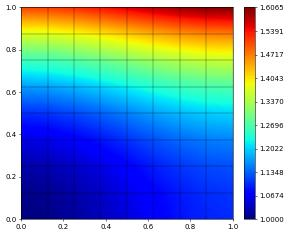

In [33]:
dt.value = 0.01
time = 0
u_h.interpolate(initial)
while time < (endTime - 1e-6):
    t.value = time
    u_h_n.assign(u_h)
    scheme.solve(target=u_h)
    time += dt.value

errors = [np.sqrt(e) for e in integrate([l2error,h1error])]
print('grid size:', gridView.size(0))
print('\t | u_h - u | =', '{:0.5e}'.format(errors[0]))
print('\t | grad(uh - u) | =', '{:0.5e}'.format(errors[1]))
u_h.plot()
gridView.writeVTK('forchheimer', pointdata={'u': u_h, 'l2error': l2error, 'h1error': h1error})

We can refine the grid once and recompute the solution on the finer grid.

grid size: 256
	 | u_h - u | = 2.69665e-06
	 | grad(uh - u) | = 2.49777e-04


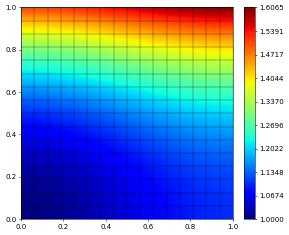

In [34]:
globalRefine(1, gridView.hierarchicalGrid)
dt.value /= 2
u_h.interpolate(initial)
time = 0
while time < (endTime - 1e-6):
    t.value = time
    u_h_n.assign(u_h)
    scheme.solve(target=u_h)
    time += dt.value

errorsFine = [np.sqrt(e) for e in integrate([l2error,h1error])]
print('grid size:', gridView.size(0))
print('\t | u_h - u | =', '{:0.5e}'.format(errorsFine[0]))
print('\t | grad(uh - u) | =', '{:0.5e}'.format(errorsFine[1]))
u_h.plot()

To check that everything is working as expected let's compute the
**experimental order of convergence** (convergence should be cubic for
$L^2$-error and quadratic for the $H^1$-error:

In [35]:
eocs = [ round(np.log(fine/coarse)/np.log(0.5),2)
         for fine,coarse in zip(errorsFine,errors) ]
print("EOCs:",eocs)

EOCs: [np.float64(2.88), np.float64(2.0)]


.. index:: Grids; Available Grids

## Listing Available Dune Components
The available realization of a given interface, i.e., the available
grid implementations, depends on the modules found during configuration.
Getting access to all available components is straightforward:

In [36]:
from dune.utility import components
# to get a list of all available components:
components()
# to get for example all available grid implementations:
components("grid")

available categories are:
 discretefunction,function,grid,model,operator,scheme,solver,space,view
available entries for this category are:
entry         function          module          
----------------------------------------------
agglomerate   polyGrid          dune.vem.vem    
alberta       albertaGrid       dune.grid       
alu           aluGrid           dune.alugrid    
aluconform    aluConformGrid    dune.alugrid    
alucube       aluCubeGrid       dune.alugrid    
alusimplex    aluSimplexGrid    dune.alugrid    
oned          onedGrid          dune.grid       
polygon       polygonGrid       dune.polygongrid
sp            spIsotropicGrid   dune.spgrid     
spanisotropic spAnisotropicGrid dune.spgrid     
spbisection   spBisectionGrid   dune.spgrid     
spisotropic   spIsotropicGrid   dune.spgrid     
ug            ugGrid            dune.grid       
yasp          yaspGrid          dune.grid       
----------------------------------------------


.. index:: Spaces; Available Spaces

Available discrete function spaces are:

In [37]:
components("space")

available entries for this category are:
entry             function          module        
------------------------------------------------
bbdg              bbdgSpace         dune.vem.vem  
bdm               bdm               dune.fem.space
combined          combined          dune.fem.space
composite         composite         dune.fem.space
dglagrange        dglagrange        dune.fem.space
dglagrangelobatto dglagrangelobatto dune.fem.space
dglegendre        dglegendre        dune.fem.space
dglegendrehp      dglegendrehp      dune.fem.space
dgonb             dgonb             dune.fem.space
dgonbhp           dgonbhp           dune.fem.space
finitevolume      finiteVolume      dune.fem.space
lagrange          lagrange          dune.fem.space
lagrangehp        lagrangehp        dune.fem.space
p1bubble          p1Bubble          dune.fem.space
product           product           dune.fem.space
rannacherturek    rannacherTurek    dune.fem.space
raviartthomas     raviartThomas     dune.fe

.. index:: Functions; Available Functions

Available grid functions are:

In [38]:
components("function")

available entries for this category are:
entry        function          module           
----------------------------------------------
discrete     discreteFunction  dune.fem.function
gridfunction gridFunction      dune.fem.function
levels       levelFunction     dune.fem.function
partitions   partitionFunction dune.fem.function
----------------------------------------------


.. index:: Scheme; Available Schemes

Available schemes:

In [39]:
components("scheme")

available entries for this category are:
entry      function         module         
-----------------------------------------
bbdg       bbdgScheme       dune.vem.vem   
dg         dg               dune.fem.scheme
dggalerkin dgGalerkin       dune.fem.scheme
galerkin   galerkin         dune.fem.scheme
h1         h1               dune.fem.scheme
h1galerkin h1Galerkin       dune.fem.scheme
linearized linearized       dune.fem.scheme
rungekutta rungeKuttaSolver dune.femdg     
vem        vemScheme        dune.vem.vem   
-----------------------------------------
